In [1]:
import sys
import os
sys.path.append("../")
sys.path.append("../..")
import numpy as np

In [2]:
# 안쓰는 코드
#inputType ='influx' # or file# Declare your own data
#from KETIPreDataIngestion import dataIngestion
#input_data = dataIngestion.inputControl(inputType)

# Make noise
#input_test_data = input_data.replace(4.0, np.nan)

## 1. Data 준비

In [3]:
from KETIPreDataIngestion.KETI_setting import influx_setting_KETI as ins
from KETIPreDataIngestion.data_influx import influx_Client
DBClient = influx_Client.influxClient(ins.CLUSTDataServer)
"""
#Test 1
db_name = 'farm_swine_vibes1'
ms_name = 'O2'
num = "2000"
column_name='O2/value'
input_data = DBClient.get_datafront_by_num(num, db_name, ms_name)[[column_name]]
"""

db_name = 'air_indoor_경로당'
ms_list = DBClient.measurement_list(db_name)
ms_name = ms_list[0]
print(ms_name)
num = "20000"
input_data = DBClient.get_datafront_by_num(num, db_name, ms_name) 
"""
db_name = "air_indoor_경로당"
ms_name = "ICL1L2000234"
number =20000
input_data = DBClient.get_dataend_by_num(number, db_name, ms_name)

"""

/home/keti/.conda/envs/torch/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (None) doesn't match a supported version!
  warnings.warn(


ICL1L2000234


'\ndb_name = "air_indoor_경로당"\nms_name = "ICL1L2000234"\nnumber =20000\ninput_data = DBClient.get_dataend_by_num(number, db_name, ms_name)\n\n'

### 1-1. Input Data Exploration

<AxesSubplot:xlabel='time'>

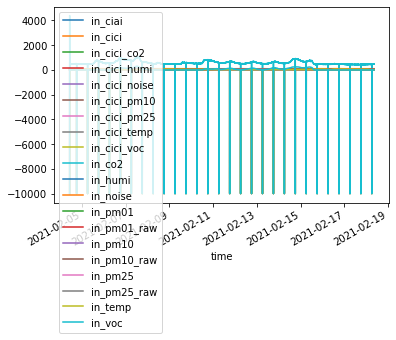

In [4]:
input_data.plot()

in_ciai          0
in_cici          0
in_cici_co2      0
in_cici_humi     0
in_cici_noise    0
in_cici_pm10     0
in_cici_pm25     0
in_cici_temp     0
in_cici_voc      0
in_co2           0
in_humi          0
in_noise         0
in_pm01          0
in_pm01_raw      0
in_pm10          0
in_pm10_raw      0
in_pm25          0
in_pm25_raw      0
in_temp          0
in_voc           0
dtype: int64

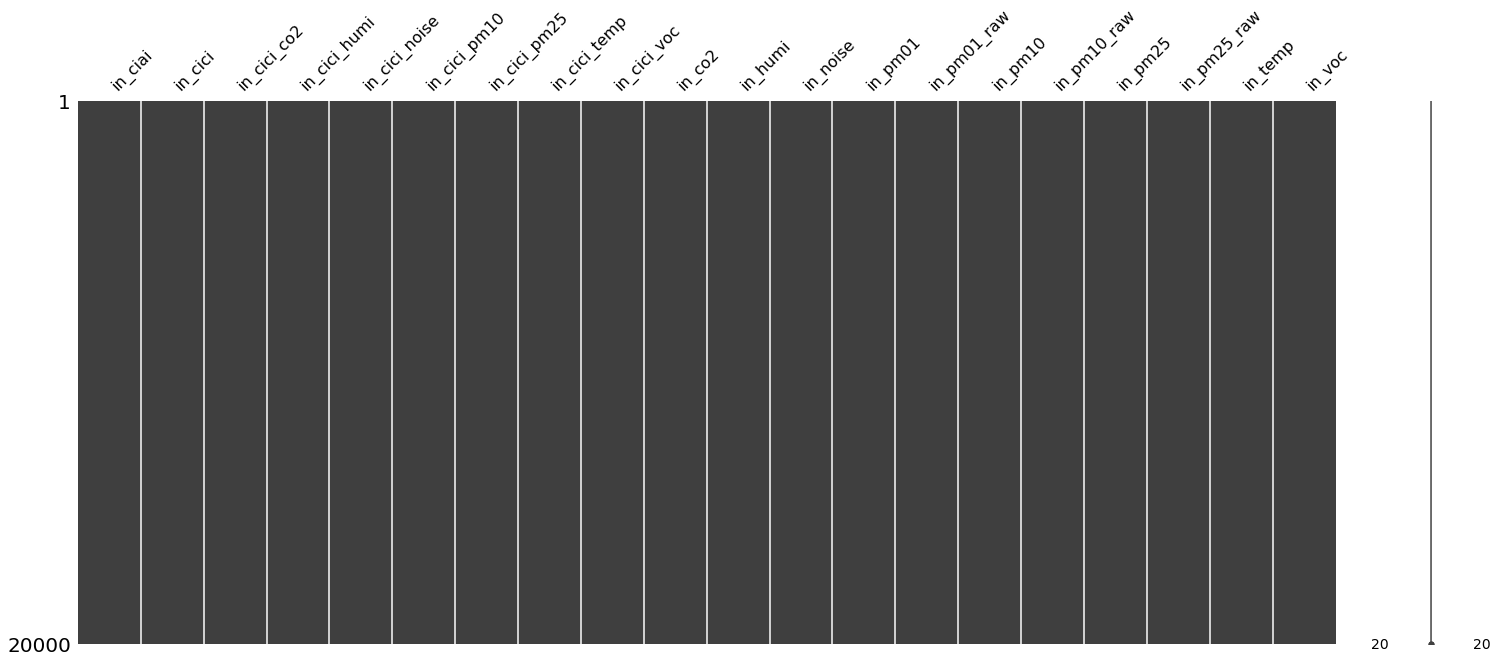

In [5]:
import missingno as msno
msno.matrix(input_data)
input_data.isna().sum()

# KETIPrePartialDataPreprocessing.data_preprocessing test

## 2. Individual Module Test
### 2-1. Refinement Test

In [6]:
# DataPreprocessing Class
data = input_data
from KETIPrePartialDataPreprocessing.data_preprocessing import DataPreprocessing

refine_param = {'removeDuplication': {'flag': True}, 'staticFrequency': {'flag': True, 'frequency': None}}
#refine_param2 = {'removeDuplication': {'flag': True}, 'staticFrequency': {'flag': True, 'frequency': "3H"}}

refinementData = DataPreprocessing().get_refinedData(data, refine_param)

in_ciai          49
in_cici          49
in_cici_co2      49
in_cici_humi     49
in_cici_noise    49
in_cici_pm10     49
in_cici_pm25     49
in_cici_temp     49
in_cici_voc      49
in_co2           49
in_humi          49
in_noise         49
in_pm01          49
in_pm01_raw      49
in_pm10          49
in_pm10_raw      49
in_pm25          49
in_pm25_raw      49
in_temp          49
in_voc           49
dtype: int64

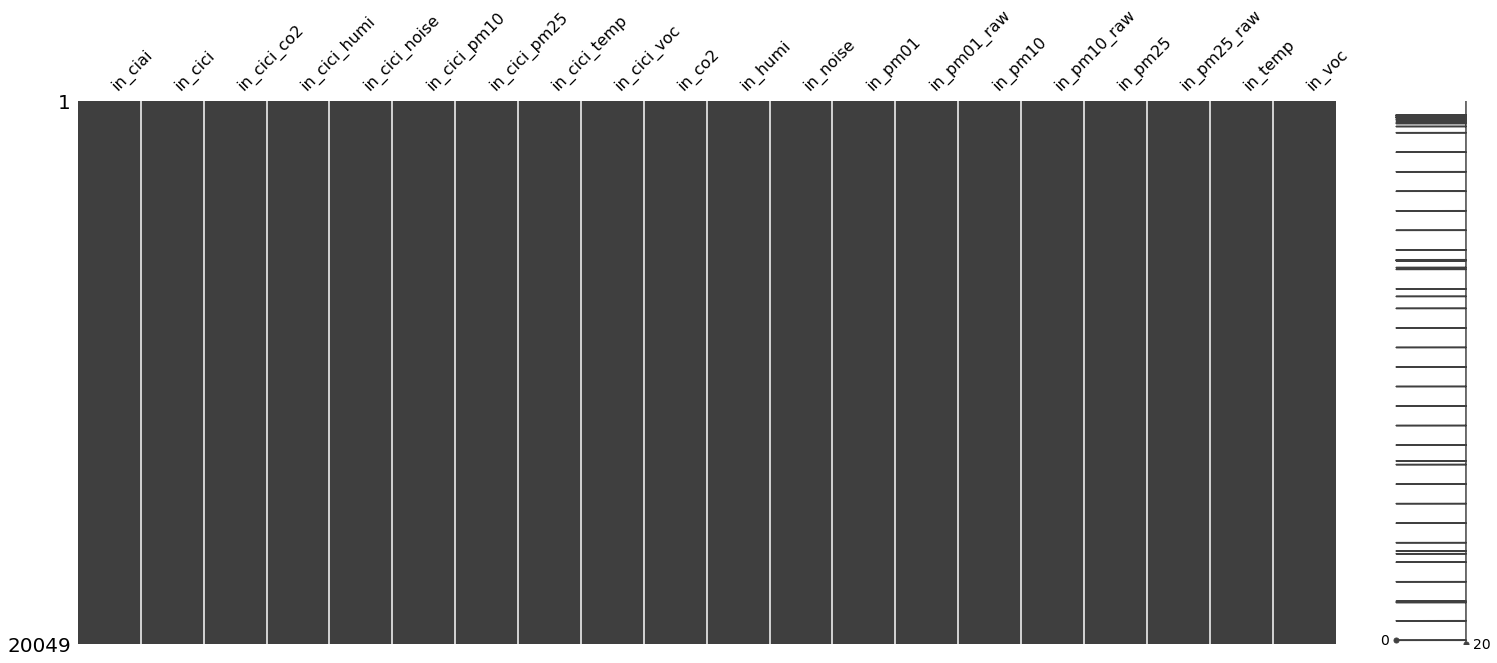

In [7]:
msno.matrix(refinementData)
refinementData.isna().sum()

## 1-2. Certain Outlier to NaN Test

In [8]:
data =refinementData
CertainParam= {'flag': True}
from KETIPrePartialDataPreprocessing.error_detection.errorToNaN import errorToNaN 
datawithMoreCertainNaN = errorToNaN().getDataWithCertainNaN(data, CertainParam)

in_ciai          49
in_cici          49
in_cici_co2      49
in_cici_humi     49
in_cici_noise    49
in_cici_pm10     49
in_cici_pm25     49
in_cici_temp     49
in_cici_voc      49
in_co2           78
in_humi          78
in_noise         78
in_pm01          49
in_pm01_raw      49
in_pm10          49
in_pm10_raw      49
in_pm25          49
in_pm25_raw      49
in_temp          78
in_voc           78
dtype: int64

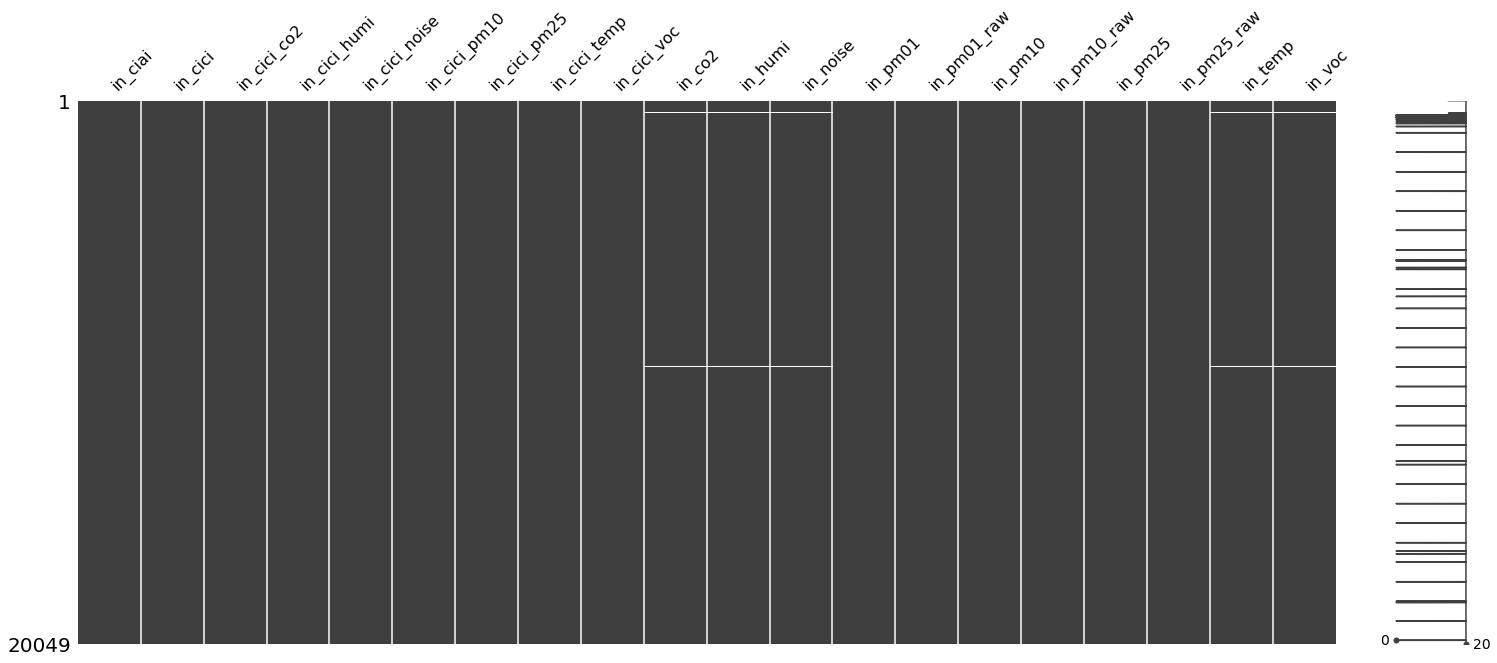

In [9]:
msno.matrix(datawithMoreCertainNaN)
datawithMoreCertainNaN.isna().sum()

<AxesSubplot:xlabel='time'>

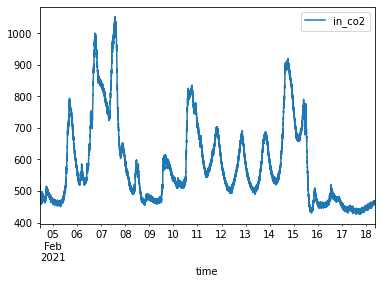

In [10]:
datawithMoreCertainNaN[['in_co2']].plot()

## 1-3. Uncertain Outlier to NaN Test

In [12]:
period = 24*60 # 해당 데이터의 주기가 24*60 정도로 추정됨
percentile1 = 99
# 예제 파라미터를 위한 셋팅
Parameter = {
    "IF":{ # Estimators (1~100)
        'IF_estimators': 100, # ensemble에 활용하는 모델 개수, i(default: 100, 데이터 크기에 적합하게 설정) 
        'IF_max_samples': 'auto', # 각 모델에 사용하는 샘플 개수(샘플링 적용), int or float(default: 'auto') 
        'IF_contamination': (100-percentile1)/100, #'auto', # 모델 학습시 활용되는 데이터의 outlier 비율, ‘auto’ or float(default: ’auto’, float인 경우 0 초과, 0.5 이하로 설정)
        'IF_max_features': 1.0, # 각 모델에 사용하는 변수 개수(샘플링 적용), int or float(default: 1.0)
        'IF_bootstrap': True}, # bootstrap적용 여부, bool(default: False)
    "KDE":{ #leafSize (1~100)
        # Multivariable 가능
        'KDE_bandwidth': 1.0, # kernel의 대역폭, float(default: 1.0)
        'KDE_algorithm': 'auto', # 사용할 tree 알고리즘, {‘kd_tree’,‘ball_tree’,‘auto’}(default: ’auto’) 중 택 1
        'KDE_kernel': 'gaussian', # kernel 종류, {'gaussian’, ‘tophat’, ‘epanechnikov’, ‘exponential’, ‘linear’, ‘cosine’}(default: ’gaussian’) 중 택 1
        'KDE_metric': 'euclidean', # 사용할 거리 척도, str(default: ’euclidean’)
        'KDE_breadth_first': True, # breadth(너비) / depth(깊이) 중 우선순위 방식 정의, bool, True: breadth or False: depth
        'KDE_leaf_size': 40}, # tree 알고리즘에서의 leaf node 개수, int(default: 40)}
    "LOF":{ # Neighbors (1~100) , leafSize (1~100, Integer)
        'LOF_neighbors': 20, # 가까운 이웃 개수, int(default: 20)
        'LOF_algorithm': 'auto', # 가까운 이웃을 정의하기 위한 알고리즘, {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}(default: ’auto’) 중 택 1
        'LOF_leaf_size': 30, # tree 알고리즘에서의 leaf node 개수, int(default: 30)
        'LOF_metric': 'minkowski', # 이웃을 정의하기 위한 거리 척도, str or callable(default: ’minkowski’)
        'LOF_contamination':0.1 # 오염 정도 (default: 0.2) (0~0.2]
    },
    "MoG": { #Components(1~100)
        'MoG_components': 1, # mixture에 활용하는 component의 개수, int(default: 1)
        'MoG_covariance': 'full', # {‘full’, ‘tied’, ‘diag’, ‘spherical’}(default: ’full’) 중 택 1
        'MoG_max_iter': 100 # EM 방법론 반복 횟수, int(default: 100)
    },
    "SR":{ 
        # Multivariable 불가능해 보임
        'SR_series_window_size': int(period/2), # less than period, int, 데이터 크기에 적합하게 설정
        'SR_spectral_window_size': period, # as same as period, int, 데이터 크기에 적합하게 설정
        'SR_score_window_size': period *2}, # a number enough larger than period, int, period보다 충분히 큰 size로 설정
    "IQR":{ # weight (1~100)
        'weight':100},
    "SD":{# limit (1~100)
        "period":period, "limit":15} 
}

In [20]:
data = datawithMoreCertainNaN
# 두개의 알고리즘을 동시에 쓰는 예제에 대해 파라미터 생성
AlgorithmList =[ 'IF', 'KDE', 'LOF', 'MoG', 'SR', 'IQR', 'SD']
UncertainParameter= {"outlierDetectorConfig":[
    {'algorithm': AlgorithmList[0], 'percentile':percentile1 ,'alg_parameter': Parameter[AlgorithmList[0]]},
    {'algorithm': AlgorithmList[1], 'percentile':percentile1 ,'alg_parameter': Parameter[AlgorithmList[1]]},
    {'algorithm': AlgorithmList[2], 'percentile':percentile1 ,'alg_parameter': Parameter[AlgorithmList[2]]},
    {'algorithm': AlgorithmList[3], 'percentile':percentile1 ,'alg_parameter': Parameter[AlgorithmList[3]]},
    {'algorithm': AlgorithmList[4], 'percentile':percentile1 ,'alg_parameter': Parameter[AlgorithmList[4]]},
    {'algorithm': AlgorithmList[5], 'percentile':percentile1 ,'alg_parameter': Parameter[AlgorithmList[5]]}
]}

algorithm1 = AlgorithmList[0]
uncertainParameter= {"outlierDetectorConfig":[
    {'algorithm': algorithm1, 'percentile':percentile1 ,'alg_parameter': Parameter[algorithm1]}
]}

uncertainParam= {'flag': True, "param":uncertainParameter}

In [21]:
# 최종 파라미터
uncertainParam

{'flag': True,
 'param': {'outlierDetectorConfig': [{'algorithm': 'IF',
    'percentile': 99,
    'alg_parameter': {'IF_estimators': 100,
     'IF_max_samples': 'auto',
     'IF_contamination': 0.01,
     'IF_max_features': 1.0,
     'IF_bootstrap': True}}]}}

In [22]:
datawithMoreUnCertainNaN = errorToNaN().getDataWithUncertainNaN(data, uncertainParam)

getDataWithUncertainNaN
{'algorithm': 'IF', 'percentile': 99, 'alg_parameter': {'IF_estimators': 100, 'IF_max_samples': 'auto', 'IF_contamination': 0.01, 'IF_max_features': 1.0, 'IF_bootstrap': True}}
IF


100%|███████████████████████████████████████████| 20/20 [00:09<00:00,  2.17it/s]


In [23]:
datawithMoreUnCertainNaN.head()

,in_ciai,in_cici,in_cici_co2,in_cici_humi,in_cici_noise,in_cici_pm10,in_cici_pm25,in_cici_temp,in_cici_voc,in_co2,in_humi,in_noise,in_pm01,in_pm01_raw,in_pm10,in_pm10_raw,in_pm25,in_pm25_raw,in_temp,in_voc
time,,,,,,,,,,,,,,,,,,,,
2021-02-04 10:33:00+00:00,NaN,NaN,NaN,80.0,80.0,93.0,93.0,NaN,NaN,NaN,NaN,NaN,19.0,19.0,20.0,20.0,11.0,11.0,NaN,NaN
2021-02-04 10:34:00+00:00,NaN,NaN,88.0,54.0,NaN,94.0,93.0,NaN,NaN,552.0,22.0,NaN,19.0,19.0,19.0,19.0,11.0,11.0,NaN,NaN
2021-02-04 10:35:00+00:00,NaN,NaN,87.0,50.0,NaN,94.0,93.0,NaN,NaN,597.0,20.0,NaN,18.0,18.0,18.0,18.0,10.0,10.0,NaN,NaN
2021-02-04 10:36:00+00:00,NaN,NaN,88.0,47.0,NaN,94.0,93.0,NaN,NaN,540.0,19.0,NaN,17.0,17.0,17.0,17.0,10.0,10.0,NaN,NaN
2021-02-04 10:37:00+00:00,NaN,NaN,89.0,47.0,80.0,94.0,93.0,NaN,NaN,521.0,19.0,54.0,17.0,17.0,18.0,18.0,10.0,10.0,NaN,NaN


in_ciai          163
in_cici          165
in_cici_co2      222
in_cici_humi     198
in_cici_noise     97
in_cici_pm10      49
in_cici_pm25     211
in_cici_temp     186
in_cici_voc      171
in_co2           275
in_humi          227
in_noise         126
in_pm01          162
in_pm01_raw      162
in_pm10          198
in_pm10_raw      198
in_pm25          117
in_pm25_raw      117
in_temp          186
in_voc           279
dtype: int64

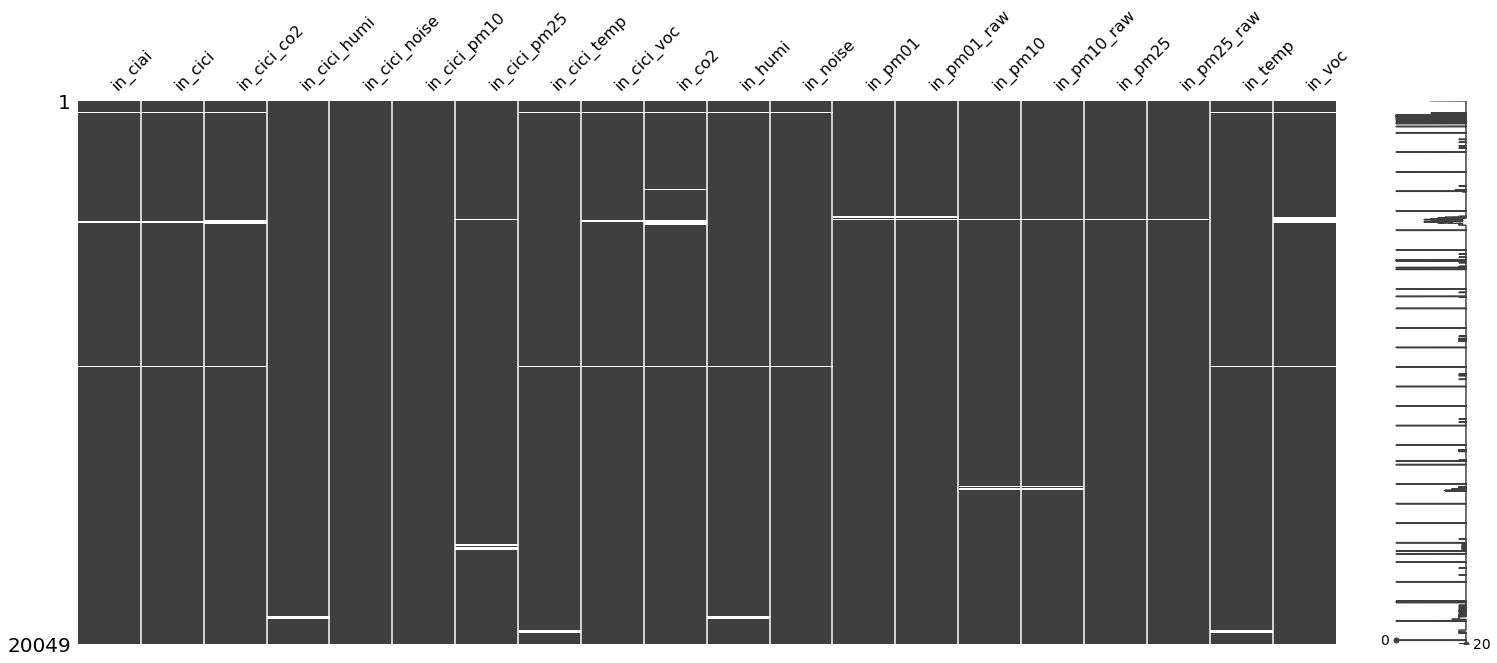

In [24]:
msno.matrix(datawithMoreUnCertainNaN)
datawithMoreUnCertainNaN.isna().sum()

### 1-4. Imputation Test

In [25]:
# Brits일 경우 더 복잡함, 향후 수정 예정
# Imputaion_method == KNN일 경우 파라미터 있음
        
imputation_param = {
"serialImputation":{
    "flag":True,
    "imputation_method":[{"min":0,"max":30,"method":"linear", "parameter":{}}, 
                          #{"min":2,"max":3,"method":"brits", "parameter":{"trainDataPathList":[db_name, ms_name]}},
                        {"min":31,"max":100,"method":"KNN", "parameter":{'n_neighbors':10, 'weights':'uniform' , 'metric':'nan_euclidean' }}
    ],
    "totalNonNanRatio":80}
}
data = datawithMoreUnCertainNaN
imputedData = DataPreprocessing().get_imputedData(data, imputation_param)

In [26]:
imputation_param

{'serialImputation': {'flag': True,
  'imputation_method': [{'min': 0,
    'max': 30,
    'method': 'linear',
    'parameter': {}},
   {'min': 31,
    'max': 100,
    'method': 'KNN',
    'parameter': {'n_neighbors': 10,
     'weights': 'uniform',
     'metric': 'nan_euclidean'}}],
  'totalNonNanRatio': 80}}

in_ciai           0
in_cici           0
in_cici_co2       0
in_cici_humi      0
in_cici_noise     0
in_cici_pm10      0
in_cici_pm25      0
in_cici_temp      0
in_cici_voc       0
in_co2           32
in_humi           0
in_noise          0
in_pm01           0
in_pm01_raw       0
in_pm10           0
in_pm10_raw       0
in_pm25           0
in_pm25_raw       0
in_temp           0
in_voc           62
dtype: int64

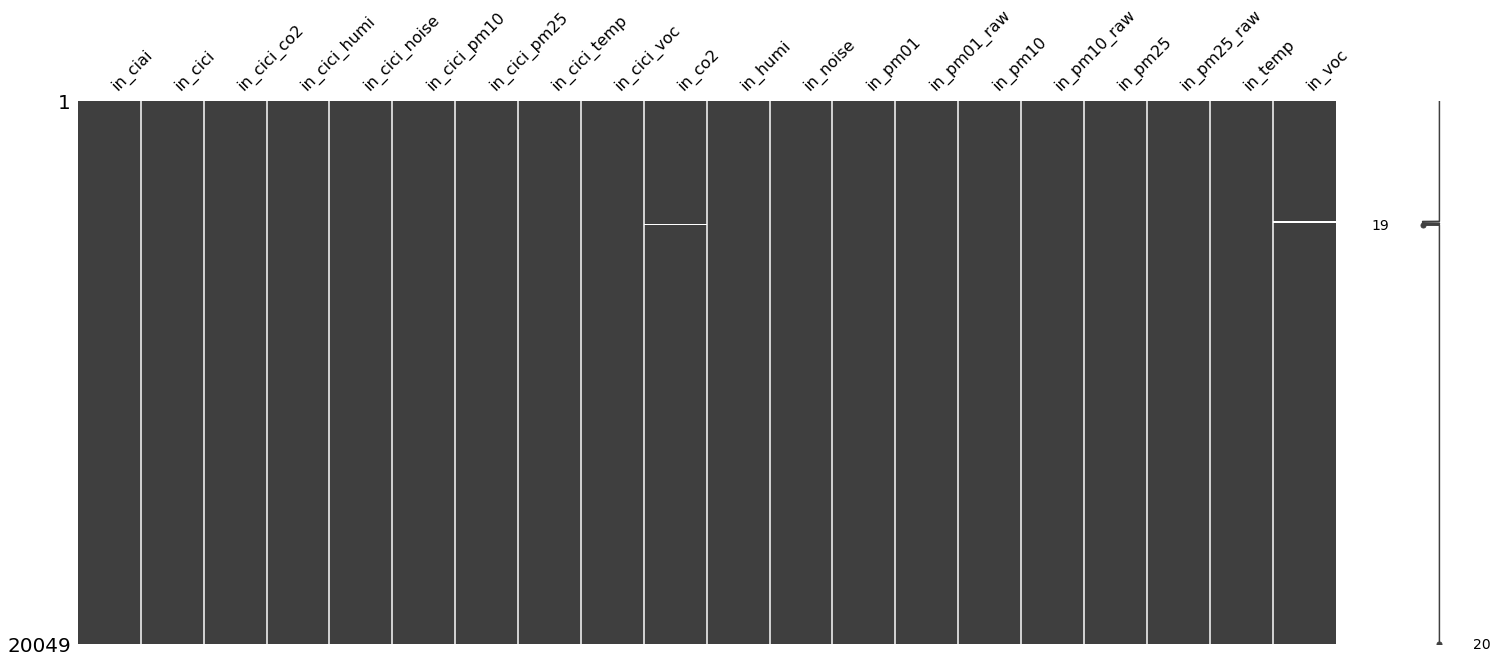

In [27]:
msno.matrix(imputedData)
imputedData.isna().sum()

## 2. Packaged Preprocessing process

In [28]:
from KETIPrePartialDataPreprocessing.data_preprocessing import packagedPartialProcessing
outlier_param ={
    "certainErrorToNaN":CertainParam, 
    "unCertainErrorToNaN":uncertainParam
}
process_param = {'refine_param':refine_param, 'outlier_param':outlier_param, 'imputation_param':imputation_param}

resultSet = packagedPartialProcessing(process_param).allPartialProcessing(input_data)

self.refine_param ::  {'removeDuplication': {'flag': True}, 'staticFrequency': {'flag': True, 'frequency': None}}
Refining-----End
getDataWithUncertainNaN
{'algorithm': 'IF', 'percentile': 99, 'alg_parameter': {'IF_estimators': 100, 'IF_max_samples': 'auto', 'IF_contamination': 0.01, 'IF_max_features': 1.0, 'IF_bootstrap': True}}
IF


100%|███████████████████████████████████████████| 20/20 [00:09<00:00,  2.22it/s]


OutlierProcessing-----End
Imputation-----End


## 3. Result

key:  original Data Leangth: 20000 Data NaN Length: in_ciai          0
in_cici          0
in_cici_co2      0
in_cici_humi     0
in_cici_noise    0
in_cici_pm10     0
in_cici_pm25     0
in_cici_temp     0
in_cici_voc      0
in_co2           0
in_humi          0
in_noise         0
in_pm01          0
in_pm01_raw      0
in_pm10          0
in_pm10_raw      0
in_pm25          0
in_pm25_raw      0
in_temp          0
in_voc           0
dtype: int64


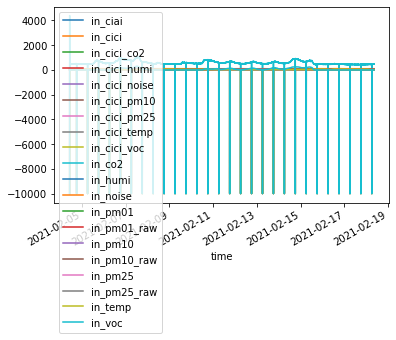

key:  refined_data Data Leangth: 669 Data NaN Length: in_ciai          0
in_cici          0
in_cici_co2      0
in_cici_humi     0
in_cici_noise    0
in_cici_pm10     0
in_cici_pm25     0
in_cici_temp     0
in_cici_voc      0
in_co2           0
in_humi          0
in_noise         0
in_pm01          0
in_pm01_raw      0
in_pm10          0
in_pm10_raw      0
in_pm25          0
in_pm25_raw      0
in_temp          0
in_voc           0
dtype: int64


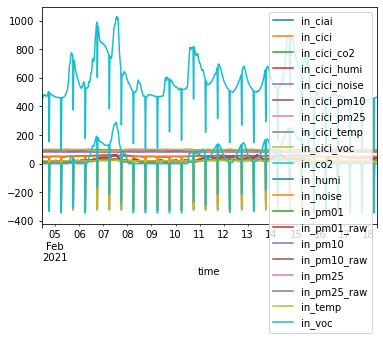

key:  datawithMoreCertainNaN Data Leangth: 669 Data NaN Length: in_ciai           0
in_cici           1
in_cici_co2       0
in_cici_humi      0
in_cici_noise     0
in_cici_pm10      0
in_cici_pm25      0
in_cici_temp      2
in_cici_voc       0
in_co2            0
in_humi          29
in_noise         29
in_pm01           0
in_pm01_raw       0
in_pm10           0
in_pm10_raw       0
in_pm25           0
in_pm25_raw       0
in_temp          29
in_voc           28
dtype: int64


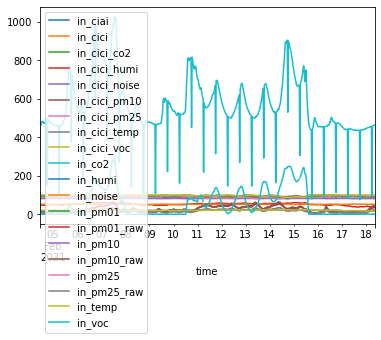

key:  datawithMoreUnCertainNaN Data Leangth: 669 Data NaN Length: in_ciai           0
in_cici           1
in_cici_co2       0
in_cici_humi      0
in_cici_noise     0
in_cici_pm10      0
in_cici_pm25      0
in_cici_temp      2
in_cici_voc       0
in_co2            0
in_humi          29
in_noise         29
in_pm01           0
in_pm01_raw       0
in_pm10           0
in_pm10_raw       0
in_pm25           0
in_pm25_raw       0
in_temp          29
in_voc           28
dtype: int64


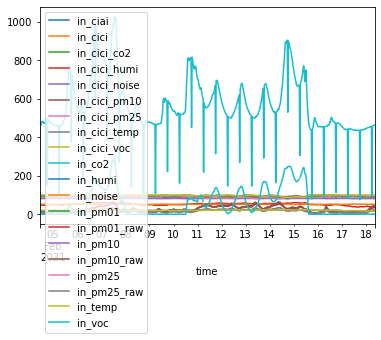

key:  imputed_data Data Leangth: 669 Data NaN Length: in_ciai           0
in_cici           1
in_cici_co2       0
in_cici_humi      0
in_cici_noise     0
in_cici_pm10      0
in_cici_pm25      0
in_cici_temp      2
in_cici_voc       0
in_co2            0
in_humi          29
in_noise         29
in_pm01           0
in_pm01_raw       0
in_pm10           0
in_pm10_raw       0
in_pm25           0
in_pm25_raw       0
in_temp          29
in_voc           28
dtype: int64


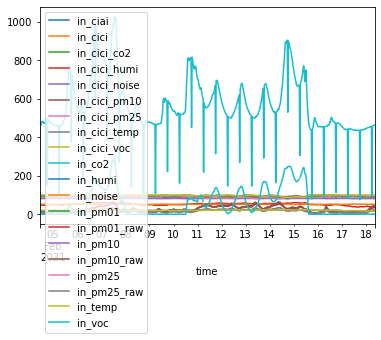

In [38]:
# Check each result
import matplotlib.pyplot as plt
for key in resultSet:
    temp = resultSet[key]
    print("key: ", key, "Data Leangth:", len(temp), "Data NaN Length:", temp.isna().sum())
    temp.plot()
    plt.show()

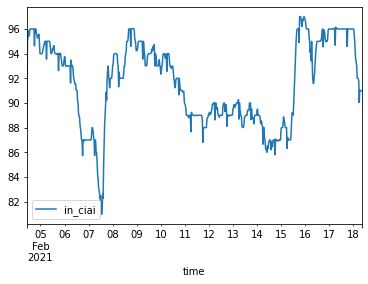

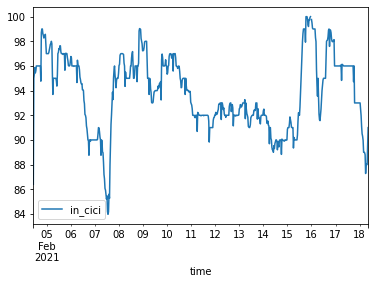

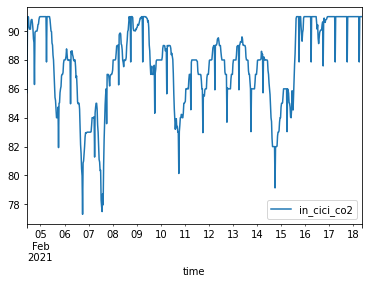

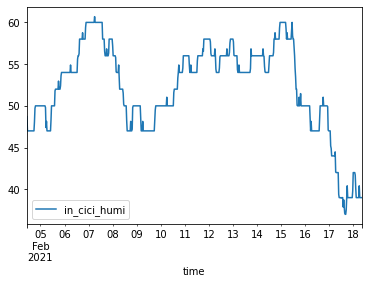

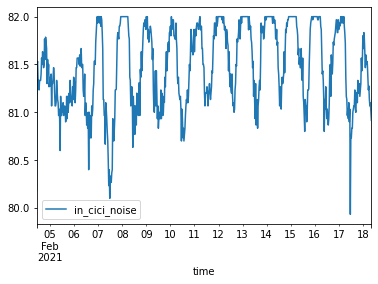

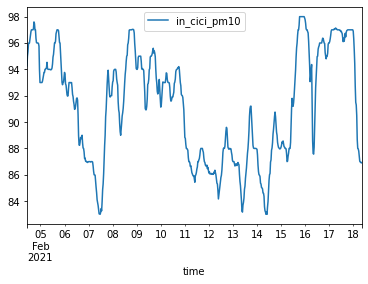

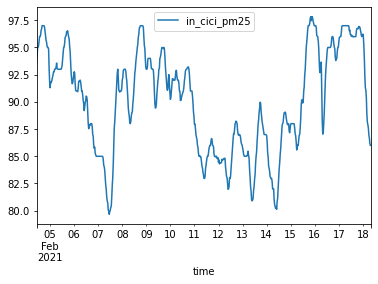

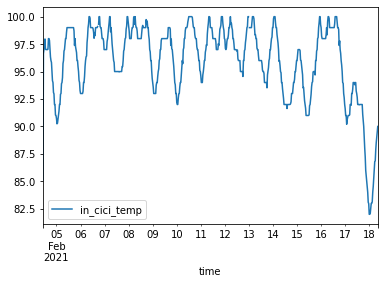

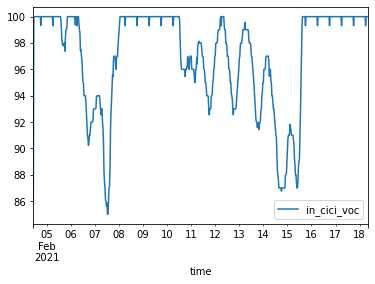

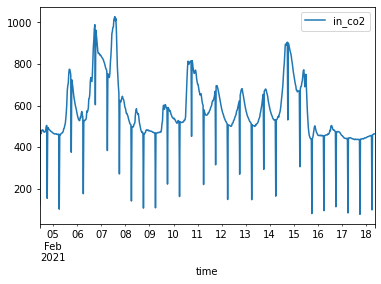

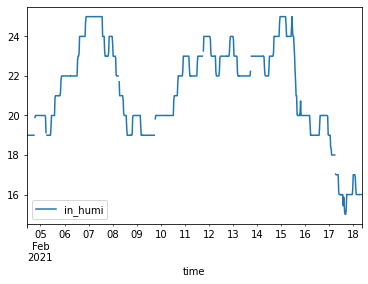

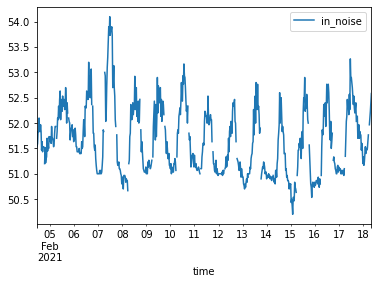

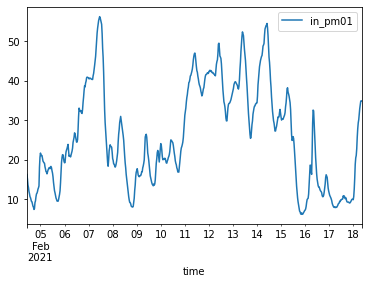

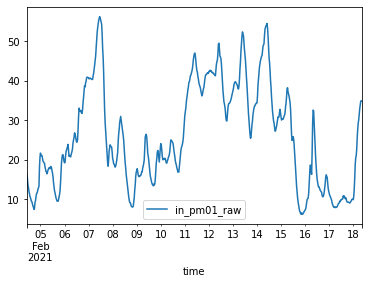

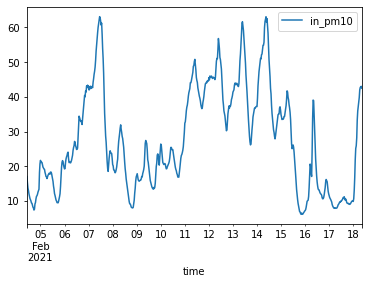

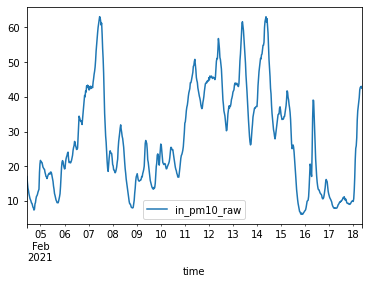

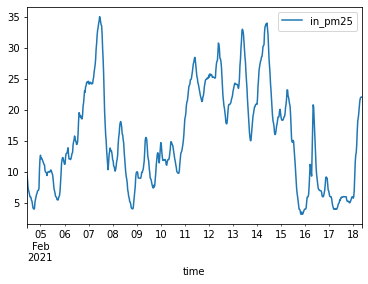

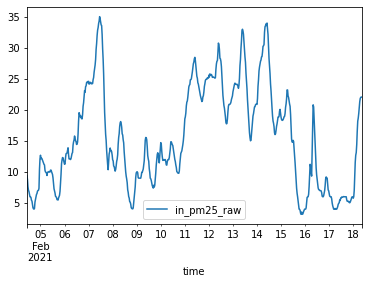

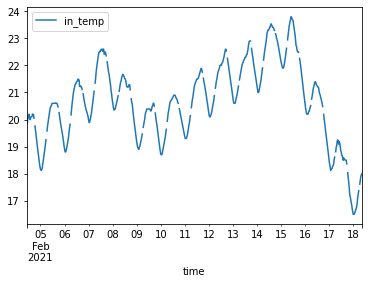

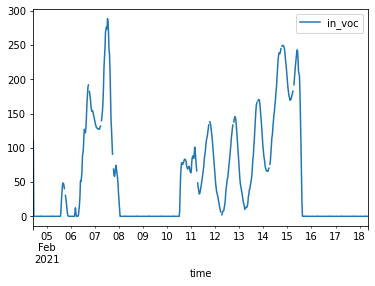

In [39]:
for column in resultSet['imputed_data'].columns:
    resultSet['imputed_data'][[column]].plot()

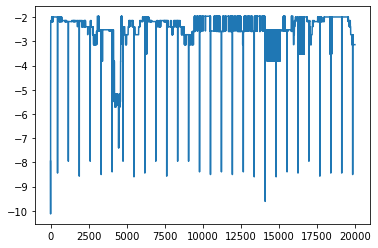

In [40]:
from sklearn.neighbors import KernelDensity
import numpy as np

test =input_data[[input_data.columns[0]]]
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(test)
log_density = kde.score_samples(test)
plt.plot(log_density)
score = - 1.0 * log_density
indexes = np.where(score > np.percentile(score, 99))[0]

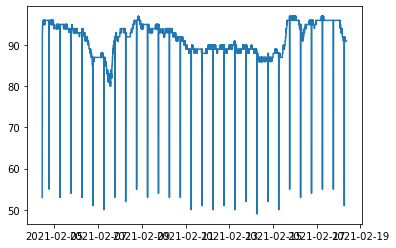

In [41]:
plt.plot(test)

In [42]:
indexes

array([    0,     1,     2,     3,     4,   460,  1169,  1888,  2607,
        3326,  4045,  4217,  4218,  4219,  4220,  4221,  4222,  4223,
        4224,  4225,  4226,  4227,  4228,  4229,  4230,  4231,  4232,
        4233,  4234,  4235,  4236,  4237,  4238,  4239,  4240,  4241,
        4242,  4243,  4244,  4245,  4246,  4247,  4248,  4249,  4250,
        4251,  4252,  4255,  4257,  4258,  4259,  4260,  4261,  4262,
        4263,  4264,  4266,  4267,  4268,  4269,  4276,  4292,  4336,
        4368,  4370,  4417,  4422,  4423,  4424,  4426,  4427,  4428,
        4429,  4430,  4433,  4434,  4435,  4436,  4437,  4438,  4439,
        4440,  4441,  4442,  4443,  4444,  4445,  4447,  4448,  4449,
        4450,  4451,  4452,  4453,  4454,  4455,  4456,  4457,  4458,
        4459,  4460,  4461,  4462,  4463,  4464,  4465,  4466,  4467,
        4468,  4469,  4470,  4471,  4472,  4473,  4474,  4475,  4476,
        4477,  4478,  4479,  4480,  4481,  4482,  4483,  4484,  4485,
        4486,  4487,

In [43]:
process_param

{'refine_param': {'removeDuplication': {'flag': True},
  'staticFrequency': {'flag': True,
   'frequency': datetime.timedelta(seconds=1800)}},
 'outlier_param': {'certainErrorToNaN': {'flag': True},
  'unCertainErrorToNaN': {'flag': False, 'param': {}}},
 'imputation_param': {'serialImputation': {'flag': False}}}

## Default Test

In [44]:
from datetime import date, timedelta
frequency_min = 30
frequencyMinTimeDelta= timedelta(minutes=frequency_min)

In [45]:
from KETIPrePartialDataPreprocessing.data_preprocessing import packagedPartialProcessing
#frequency = [None| DateOffset|Timedelta|str]
refine_param = {'removeDuplication': {'flag': True}, 'staticFrequency': {'flag': True, 'frequency': frequencyMinTimeDelta}}
CertainParam= {'flag': True}
uncertainParam= {'flag': False, "param":{}}
outlier_param ={
    "certainErrorToNaN":CertainParam, 
    "unCertainErrorToNaN":uncertainParam
}
imputation_param = {
"serialImputation":{"flag":False}
}

process_param = {'refine_param':refine_param, 'outlier_param':outlier_param, 'imputation_param':imputation_param}
resultSet = packagedPartialProcessing(process_param).allPartialProcessing(input_data)

self.refine_param ::  {'removeDuplication': {'flag': True}, 'staticFrequency': {'flag': True, 'frequency': datetime.timedelta(seconds=1800)}}
Refining-----End
OutlierProcessing-----End
Imputation-----End


In [46]:
resultSet.keys()

dict_keys(['original', 'refined_data', 'datawithMoreCertainNaN', 'datawithMoreUnCertainNaN', 'imputed_data'])